<a href="https://colab.research.google.com/github/amr-elbana/AI-driven-post-harvest-sorting-system/blob/amr-elbana-inceptionV3/classification-Models/Augmented_Dataset_Models/InceptionV3_Orange_Classification_Healthy_vs_Rotten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
!cp -r "/content/drive/MyDrive/Graduation Project 24 25/Dataset/Splitted dataset" /content/data

In [4]:
dataset_base_path = "/content/data"  # Store the base path
model_save_path = "/content/drive/MyDrive/Graduation Project 24 25/Trained Models/inceptionV3_Model/Augmented model"
final_model_path = os.path.join(model_save_path, "Fine_Tuning_InceptionV3_best_model.keras")
plot_save_path = os.path.join(model_save_path, "training_plots.png")
history_file_path = os.path.join(model_save_path, "training_history.json")
results_save_path = os.path.join(model_save_path, "orange_InceptionV3_results.txt")
conf_matrix_save_path = os.path.join(model_save_path, "orange_InceptionV3_confusion_matrix.png")

In [5]:
# Define paths and constants
data_dir = os.path.join(dataset_base_path, "train-2")
val_dir = os.path.join(dataset_base_path, "validation")
test_dir = os.path.join(dataset_base_path, "test")
batch_size = 32
target_size = (299, 299)
epochs = 30

# **Datset**

In [6]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Create an ImageDataGenerator with InceptionV3 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # InceptionV3-specific preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'     # Fill in missing pixels using the nearest neighbor
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to InceptionV3 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Create an ImageDataGenerator with InceptionV3 preprocessing and data augmentation
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # InceptionV3-specific preprocessing
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,      # Resize images to InceptionV3 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)

# ... (rest of the code remains the same)

# Check the number of samples in each generator
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 6368 images belonging to 2 classes.
Found 297 images belonging to 2 classes.
Training samples: 6368
Validation samples: 297
Training batches per epoch: 199
Validation batches per epoch: 10


In [7]:
# Create an ImageDataGenerator for InceptionV3 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # InceptionV3-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 373 images belonging to 2 classes.
Test samples: 373
Test batches: 12


# **Model Architecture**

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score

# Load InceptionV3 base model with pre-trained weights
base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = layers.Flatten()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = layers.Dropout(0.3)(x)  # Reduced dropout rate
x = layers.Dense(1, activation='sigmoid')(x)

# Combine base model with new layers
model = Model(base_model.input, x)

# Compile the model with Adam optimizer and additional metrics
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Increased learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 55,882,017 (213.17 MB)

 Trainable params: 33,817,089 (129.00 MB)

 Non-trainable params: 22,064,928 (84.17 MB)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = os.path.join(model_save_path, "InceptionV3_{epoch:02d}-{val_accuracy:0.2f}-{val_loss:.4f}.keras")

# Define callbacks
checkpoint = ModelCheckpoint(
    checkpoint_path,  # Save the best model
    monitor='val_accuracy',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='max'  # Minimize validation loss
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=4,  # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=2,  # Wait for 3 epochs without improvement
    min_lr=1e-7  # Minimum learning rate
)

# Train the model
history = model.fit(
    train_generator,  # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=20,  # Number of epochs
    callbacks=[checkpoint, early_stopping, reduce_lr],  # Callbacks
)
model.save(final_model_path)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.8352 - loss: 5.9132 - val_accuracy: 0.9360 - val_loss: 4.3187 - learning_rate: 1.0000e-04
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9043 - loss: 4.7555 - val_accuracy: 0.9327 - val_loss: 3.8437 - learning_rate: 1.0000e-04
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9327 - loss: 3.7806 - val_accuracy: 0.9226 - val_loss: 3.2503 - learning_rate: 1.0000e-04
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9275 - loss: 3.4145 - val_accuracy: 0.9360 - val_loss: 2.9759 - learning_rate: 1.0000e-04
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.9412 - loss: 2.9270 - val_accuracy: 0.9663 - val_loss: 2.4318 - learning_rate: 1.0000e-04
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9389 - loss: 2.6585 - val_accuracy: 0.9562 - val_loss: 2.2319 - learning_rate: 1.0000e-04
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.94

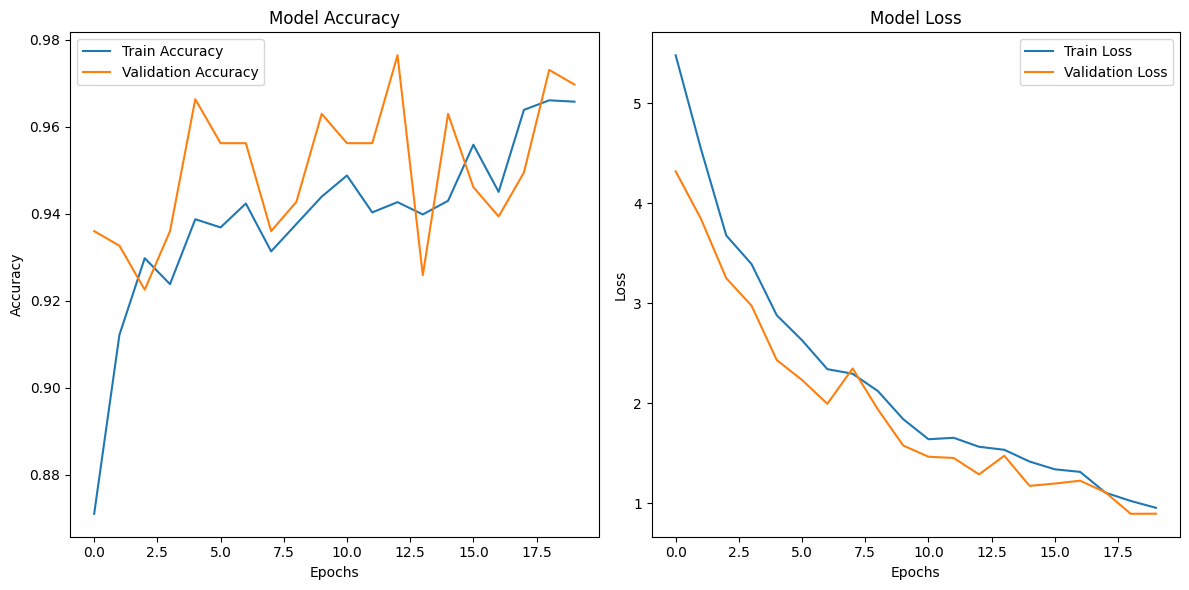

Plot saved to: /content/drive/MyDrive/Graduation Project 24 25/Trained Models/inceptionV3_Model/Augmented model/training_plots.png


In [13]:
import matplotlib.pyplot as plt

# The history variable already contains the training history
# No need to call history.history again

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')  # Changed 'acc' to 'accuracy'
plt.plot(history['val_accuracy'], label='Validation Accuracy')  # Changed 'val_acc' to 'val_accuracy'
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Change to your desired path
# Save the figure
plt.savefig(plot_save_path)
plt.show()

print(f"Plot saved to: {plot_save_path}")

In [15]:
final_train_acc = history['accuracy'][-1]  # Changed History to history and 'acc' to 'accuracy'
final_val_acc = history['val_accuracy'][-1]  # Changed History to history and 'val_acc' to 'val_accuracy'
final_train_loss = history['loss'][-1]  # Changed History to history
final_val_loss = history['val_loss'][-1]  # Changed History to history

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.9658
Final Validation Accuracy: 0.9697
Final Training Loss: 0.9543
Final Validation Loss: 0.8957


In [18]:
print(f"Training stopped at epoch: {len(history['loss'])}")  # Access 'loss' directly from the history dictionary

Training stopped at epoch: 20


In [19]:
import json
import os  # Import the os module

history_file_path = os.path.join(model_save_path, "training_history.json")

# Save history to a JSON file on Google Drive
with open(history_file_path, "w") as f:
    json.dump(history, f)  # Use 'history' instead of 'History.history'

# Load the history later
with open(history_file_path, "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'accuracy': [0.8710741400718689, 0.9122173190116882, 0.9298052787780762, 0.9238379597663879, 0.9387562870979309, 0.9368718862533569, 0.9423680901527405, 0.9313756227493286, 0.9376570582389832, 0.9439384341239929, 0.9488065242767334, 0.9403266310691833, 0.942682147026062, 0.9398555159568787, 0.9429962038993835, 0.9558731317520142, 0.9450376629829407, 0.9638819098472595, 0.9660804271697998, 0.9657663106918335], 'loss': [5.479218482971191, 4.543178558349609, 3.67803955078125, 3.391657590866089, 2.879197120666504, 2.6294000148773193, 2.340623140335083, 2.294891357421875, 2.121553659439087, 1.8408786058425903, 1.6401561498641968, 1.654404878616333, 1.5649110078811646, 1.5344849824905396, 1.416882872581482, 1.3393462896347046, 1.3138295412063599, 1.105966329574585, 1.0231870412826538, 0.9543119072914124], 'val_accuracy': [0.936026930809021, 0.932659924030304, 0.9225589036941528, 0.936026930809021, 0.9663299918174744, 0.9562289714813232, 0.9562289714813232, 0.936026930809021, 0.9427609443664

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
model = tf.keras.models.load_model(final_model_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Healthy', 'Rotten'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 133s 11s/step
Confusion Matrix:
 [[185   0]
 [  4 184]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.98      1.00      0.99       185
      Rotten       1.00      0.98      0.99       188

    accuracy                           0.99       373
   macro avg       0.99      0.99      0.99       373
weighted avg       0.99      0.99      0.99       373


Accuracy: 0.9892761394101877

F1 Score: 0.989247311827957


In [21]:
# Define where to save everything
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/Graduation Project 24 25/Trained Models/inceptionV3_Model/Augmented model/orange_InceptionV3_results.txt


In [22]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Rotten"], yticklabels=["Healthy", "Rotten"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/Graduation Project 24 25/Trained Models/inceptionV3_Model/Augmented model/orange_InceptionV3_confusion_matrix.png
